# LSTM and GRU Models for PTB data
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: Oversampling  
rescaling: Standard

If you don't have the original files: run the notebook `preprocessing_ptb_standard_oversampling.ipynb`     
Input file:(The preprocessed data)     
ptb_train_clean_standard_oversampling.csv (Standard Scaled data)  
ptb_test_clean_standard_oversampling.csv  (Standard Sscaled data)   

Output: lstm model trained  
model_ptb_lstm.h5  

| **Feature**                     | **LSTM**                                                      | **GRU**                                                 |
|---------------------------------|---------------------------------------------------------------|---------------------------------------------------------|
| **Types of Gates**              | 3 gates: Input, Forget, Output                                | 2 gates: Update, Reset                                  |
| **Memory Structure**            | Keeps two kinds of memory: cell and hidden                    | Only one memory type: hidden                            |
| **Computational Demand**        | Uses more power and memory                                    | Uses less power and memory                              |
| **Training Speed**              | Takes more time to train                                      | Trains faster                                           |
| **Best for Long Sequences**     | Great for remembering long sequences and details              | Good for simpler, shorter sequences                     |
| **When to Use**                 | When you need to remember a lot of details over a long period | When you want quicker training with fewer details       |


In [1]:
import sys
import os

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q
    !pip install tensorflow -q
    !pip install matplotlib -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive.
    data_path = '/content/drive/MyDrive/data/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on Google Colab
Mounted at /content/drive


## Read data


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax


RawFiles = dict({
    'train': data_path + 'ptb_train_clean_standard_oversampling.csv',
    'test': data_path + 'ptb_test_clean_standard_oversampling.csv'
})

OutputFiles = dict({
    'model': model_output_path +  'model_ptb_lstm'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [3]:
X_train.shape

(16796, 187)

# LSTM with Standard Scaler and Oversampling

In [4]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train.shape)  # samples, timesteps, features
print("X_test shape:", X_test.shape)    # samples, timesteps, features


X_train shape: (16796, 187, 1)
X_test shape: (2911, 187, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(187, activation='tanh', return_sequences=True))

# Hidden layers
model.add(LSTM(16, activation='tanh'))
model.add(Dropout(0.3))

# Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Choose an optimizer with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)

# Lists to store metrics over epochs
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size and number of epochs
batch_size = 32
epochs = 100

# Training loop on the full dataset
for epoch in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size,
                        validation_data=(X_test, y_test), verbose=0,
                        callbacks=[early_stopping, lr_scheduler])

    # Append metrics to respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Predictions and optimal threshold calculation on the test set
y_pred_test = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Convert probabilities to binary predictions based on optimal threshold
y_pred_class_test = (y_pred_test >= optimal_threshold).astype(int)

# Model Evaluation on the test set
print("Evaluation on Test Set")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class_test))
print(f"F1 Score: {f1_score(y_test, y_pred_class_test):.4f}")

# Predictions on the full training set (X_train) using the optimal threshold
y_pred_full_train = model.predict(X_train)
y_pred_class_full_train = (y_pred_full_train >= optimal_threshold).astype(int)

# Model Evaluation on the full training set
print("\nEvaluation on Full Training Set")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_class_full_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_class_full_train))
print(f"F1 Score: {f1_score(y_train, y_pred_class_full_train):.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 187, 187)            │         141,372 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │          13,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,445 (603.30 KB)

 Trainable params: 154,445 (603.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10/100 - Loss: 0.4844, Val Loss: 0.4678, Accuracy: 0.7774, Val Accuracy: 0.7386
Epoch 20/100 - Loss: 0.4160, Val Loss: 0.3928, Accuracy: 0.8138, Val Accuracy: 0.7946
Epoch 30/100 - Loss: 0.3340, Val Loss: 0.3438, Accuracy: 0.8615, Val Accuracy: 0.8351
Epoch 40/100 - Loss: 0.3049, Val Loss: 0.3024, Accuracy: 0.8858, Val Accuracy: 0.8674
Epoch 50/100 - Loss: 0.2615, Val Loss: 0.3060, Accuracy: 0.9031, Val Accuracy: 0.8770
Epoch 60/100 - Loss: 0.2339, Val Loss: 0.3281, Accuracy: 0.9162, Val Accuracy: 0.8763
Epoch 70/100 - Loss: 0.2104, Val Loss: 0.2569, Accuracy: 0.9285, Val Accuracy: 0.9093
Epoch 80/100 - Loss: 0.1774, Val Loss: 0.2110, Accuracy: 0.9379, Val Accuracy: 0.9172
Epoch 90/100 - Loss: 0.1709, Val Loss: 0.2264, Accuracy: 0.9420, Val Accuracy: 0.9248
Epoch 100/100 - Loss: 0.1502, Val Loss: 0.2194, Accuracy: 0.9519, Val Accuracy: 0.9261
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Optimal Threshold: 0.52
Evaluation on Test Set
Confusion Matrix:
 [[ 762   41]
 [ 171 1937]]

Classi

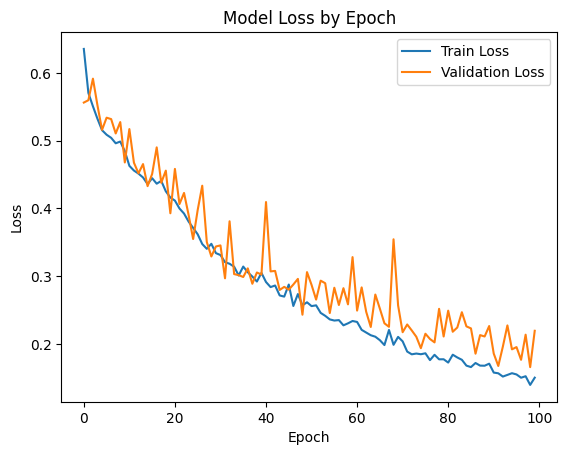

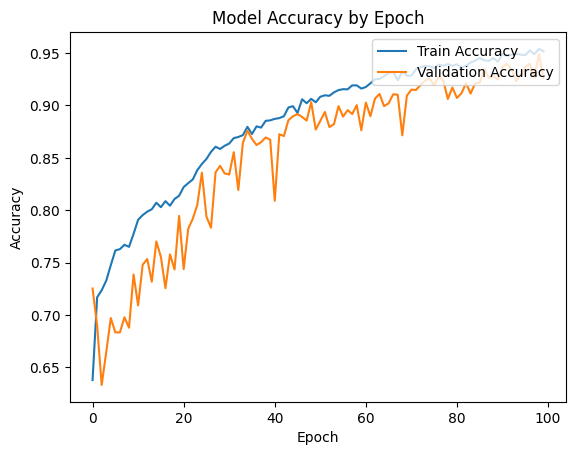

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
 [[ 758   45]
 [ 170 1938]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88       803
           1       0.98      0.92      0.95      2108

    accuracy                           0.93      2911
   macro avg       0.90      0.93      0.91      2911
weighted avg       0.93      0.93      0.93      2911

F1 Score: 0.9474


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions using the best model (with best weights)
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)  # Using 0.5 as the threshold for binary classification

# Evaluating the best-performing model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")

### Save model

In [8]:
# Save the model with TensorFlow format
model_path = OutputFiles.get('model') + '.h5'  # Append .h5 extension
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/data/model_ptb_lstm.h5


In [9]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-14 15:55:26.762296
